In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd

def f(X, theta):
    return X @ theta

def loss(theta, X, y):
    y_pred = f(X, theta)
    error = np.square(y_pred - y)
    return np.mean(error)

def grad_loss(theta, X, y):
    y_pred = f(X, theta)
    return (2 / len(y)) * X.T @ (y_pred - y)

def SGD(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs):
    X, y = D  # Unpack the data
    N = X.shape[0] # We assume both X and Y has shape (N, )
    d = theta0.shape[0] # While theta0 has shape (d, )
    idx = np.arange(0, N) # This is required for the shuffling
    
    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch
    loss_history = np.zeros((n_epochs, ))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs, ))  # Save gradient norms at each epoch
    
    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Shuffle the data at the beginning of each epoch

        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Initialize a vector that saves the gradient of the loss at each iteration
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            
            # Compute the gradient of the loss
            gradient = grad_loss(theta, X_batch, y_batch)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            # Update weights
            theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        loss_history[epoch] = loss(theta, X, y)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)
    
    return theta_history, loss_history, grad_norm_history

In [2]:
# Split data into training and testing
def split_data(X, y):
    d, N = X.shape
    N_train = int(0.8 * d)
    idx = np.arange(d)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    X_train = X[train_idx, :]
    Y_train = y[train_idx]
    X_test = X[test_idx, :]
    Y_test = y[test_idx]


    return (X_train, Y_train), (X_test, Y_test)

The shape of x = (1000,) and y = (1000,)


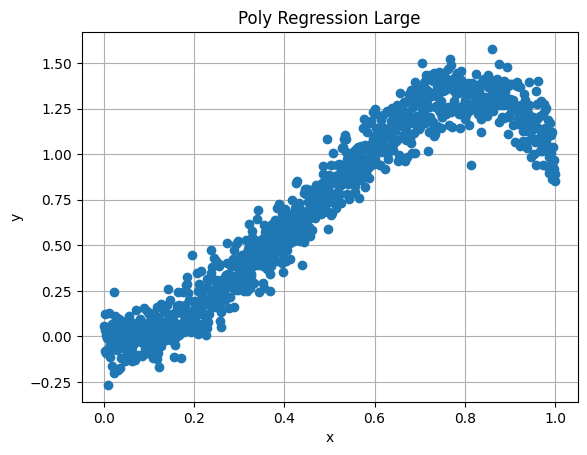

In [3]:
# Load data
data = pd.read_csv("poly_regression_large.csv")
x, y = data["x"].values, data["y"].values

# define k for polynomial
K = 5
print(f'The shape of x = {x.shape} and y = {y.shape}')

# Visualize the data
plt.plot(x, y, 'o')
plt.title("Poly Regression Large")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

In [4]:
# Define the Vandermonde matrix
def vandermonde(x, K):
    N = len(x)
    PhiX = np.zeros((N, K))
    for i in range(K):
        PhiX[:, i] = x**i
    return PhiX   

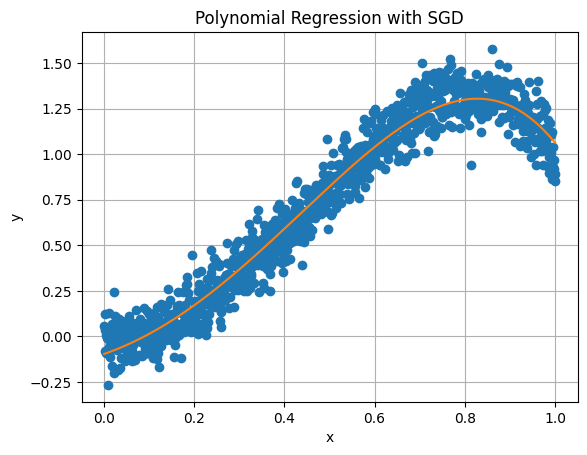

In [23]:
# Train the polynomial regression model on the training set via the Stochastic Gradient Descent algorithm
phiX = vandermonde(x, K)

# Split the data
(train_X, train_y), (test_X, test_y) = split_data(phiX, y)

# initialize infos
theta0 = np.zeros(K)
alpha = 0.1
batch_size = 25
n_epochs = 500

# Train SGD model
theta_history_sgd, loss_history_sgd, grad_norm_history_sgd = SGD(loss, grad_loss, (train_X, train_y), theta0, alpha, batch_size, n_epochs)

# Test the model
test_loss_sgd = loss(theta_history_sgd[-1], test_X, test_y)

plt.plot(x, y, 'o')
plt.plot(x, f(phiX, theta_history_sgd[-1]))
plt.title("Polynomial Regression with SGD")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()


In [24]:
# Train the polynomial regression model on the training set via the Gradient Descent algorithm.
def GD(f, grad_f, x0, alpha, maxit=1000, tolf=1e-6, tolx=1e-6):
    # initialize the infos
    f_val = np.zeros((maxit+1,))
    grad_norm = np.zeros((maxit+1,))

    # set the values for infos for x0
    f_val[0] = f(x0)
    grad_norm[0] = np.linalg.norm(grad_f(x0))
    xk = x0
    for k in range(maxit):
        x = xk - alpha * grad_f(xk)

        # Update the infos
        f_val[k+1] = f(x)
        grad_norm[k+1] = np.linalg.norm(grad_f(x))

        if grad_norm[k+1] <= tolf * grad_norm[0] or np.linalg.norm(x - xk) <= tolx:
            break
        xk = x
    
    # cut off exceeding values
    f_val = f_val[:k+1]
    grad_norm = grad_norm[:k+1]

    return x, k, f_val, grad_norm

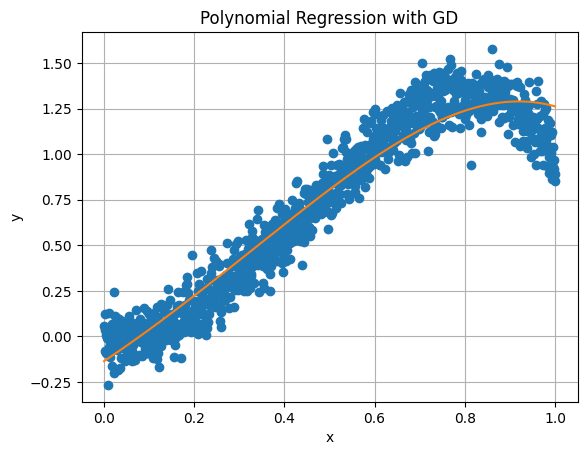

In [27]:
# Loss and gradient function for GD
def f_loss(theta):
    return loss(theta, train_X, train_y)

def f_grad_loss(theta):
    return grad_loss(theta, train_X, train_y)

# Train GD model
x_sol, k, f_val, grad_norm = GD(f_loss, f_grad_loss, theta0, alpha=0.08)

# Test the model
test_loss_gd = loss(x_sol, test_X, test_y)

# Plot the result
plt.plot(x, y, 'o')
plt.plot(x, f(phiX, x_sol), '-')
plt.title("Polynomial Regression with GD")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

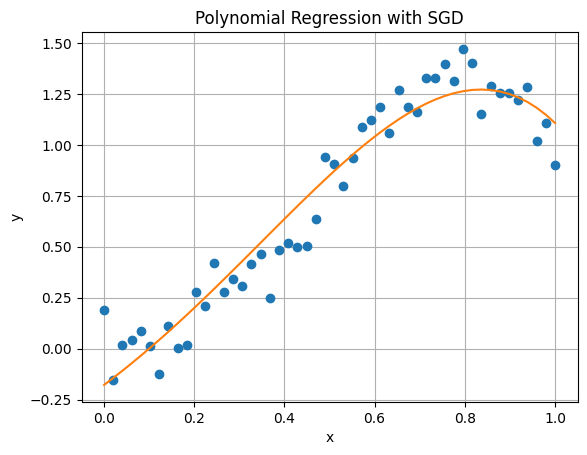

In [26]:
data_small = pd.read_csv("./poly_regression_small.csv")
x_small, y_small = data_small["x"].values, data_small["y"].values

# Train the polynomial regression model on the training set via the Stochastic Gradient Descent algorithm
phiX_small = vandermonde(x_small, K)

# initialize infos
theta0 = np.zeros(K)
alpha = 0.25
batch_size = 30
n_epochs = 500

# Train SGD model
theta_history_sgd_small, loss_history_sgd_small, grad_norm_history_sgd_small = SGD(loss, grad_loss, (phiX_small, y_small), theta0, alpha, batch_size, n_epochs)

# Test the model
test_loss_sgd_small = loss(theta_history_sgd_small[-1], phiX_small, y_small)

plt.plot(x_small, y_small, 'o')
plt.plot(x_small, f(phiX_small, theta_history_sgd_small[-1]))
plt.title("Polynomial Regression with SGD")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

In [22]:
# Compare the performance of the three regression model computed above

print(f"Test Error (Gradient Descent on Train Set): {test_loss_gd}")
print(f"Test Error (Stochastic Gradient Descent on Train Set): {test_loss_sgd}")
print(f"Test Error (Stochastic Gradient Descent on Full set): {test_loss_sgd_small}")

# Comment on performance
errors = {"GD": test_loss_gd, "SGD": test_loss_sgd, "SGD with Full set": test_loss_sgd_small}
best_model = min(errors, key=errors.get)
print(f"\nThe best performing model on the test set is: {best_model}")

Test Error (Gradient Descent on Train Set): 0.018447627001902757
Test Error (Stochastic Gradient Descent on Train Set): 0.012066436025731944
Test Error (Stochastic Gradient Descent on Full set): 0.016736409895956553

The best performing model on the test set is: SGD


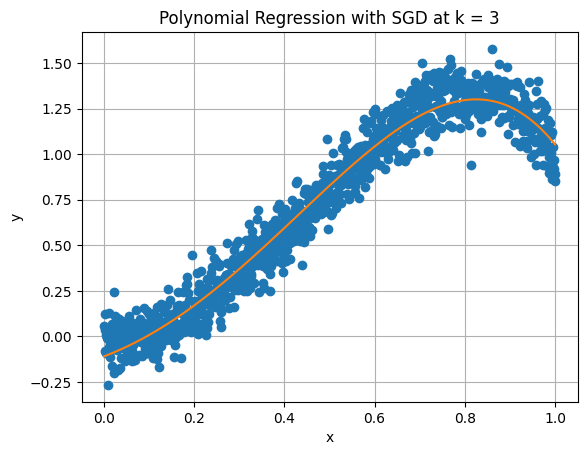

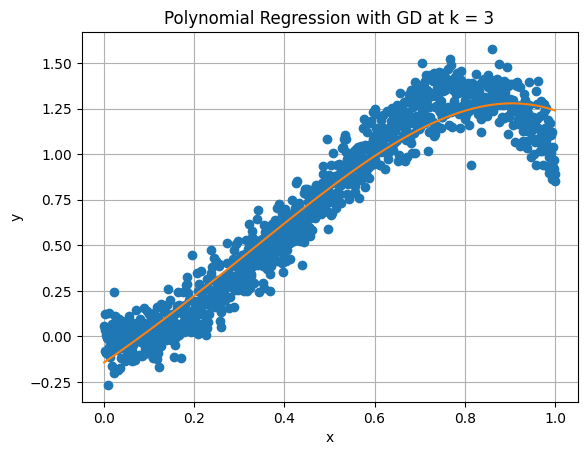

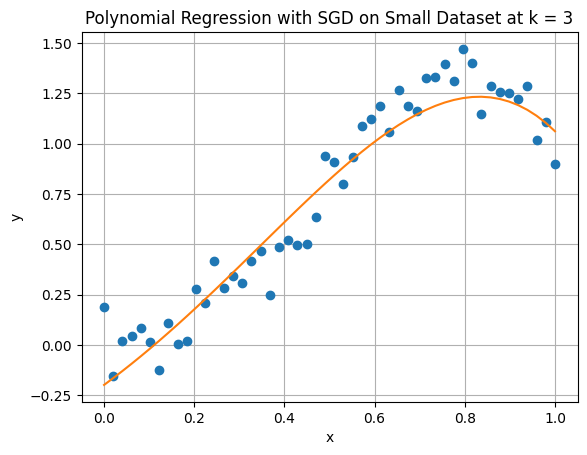

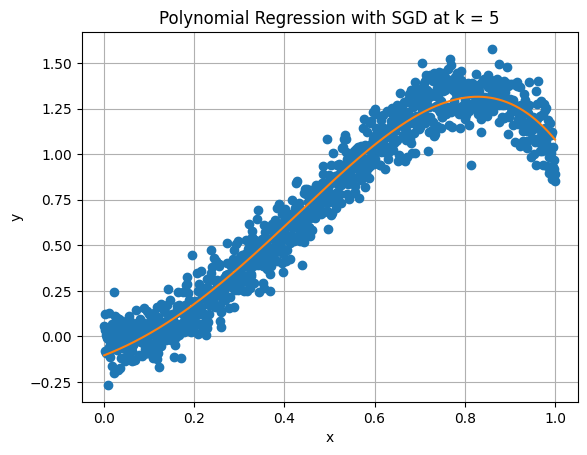

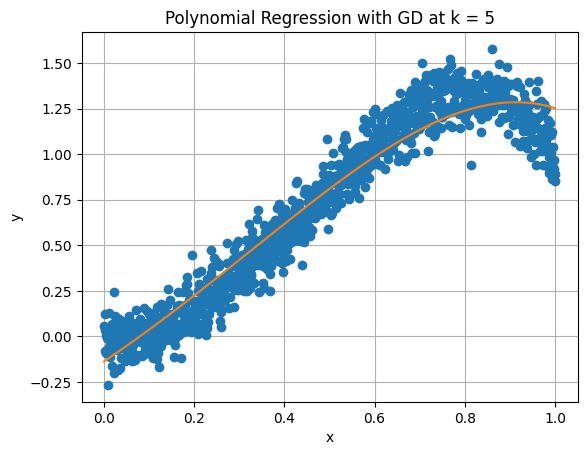

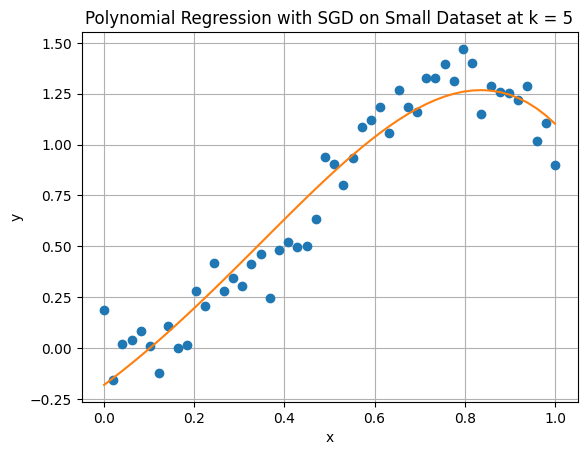

The true paramters are [ 0  0  4  0 -3]
The SGD paramters are [-0.10450227  0.95982187  2.30392994  0.23601489 -2.31439336]
The GD paramters are [-0.13798544  1.67521285  0.74542155 -0.18102428 -0.84825075]
The SGD paramters are [-0.18058642  1.65763373  1.23552494 -0.15256621 -1.45726854]


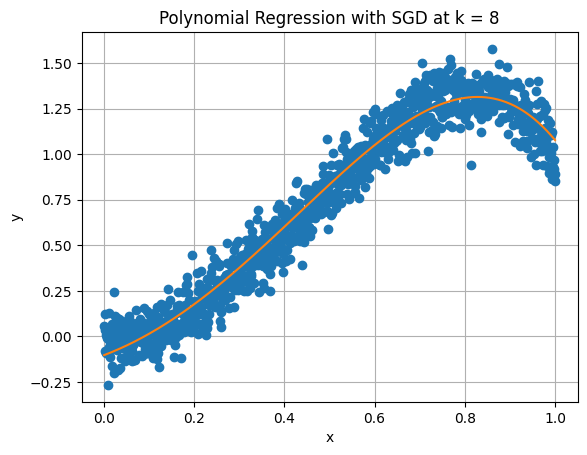

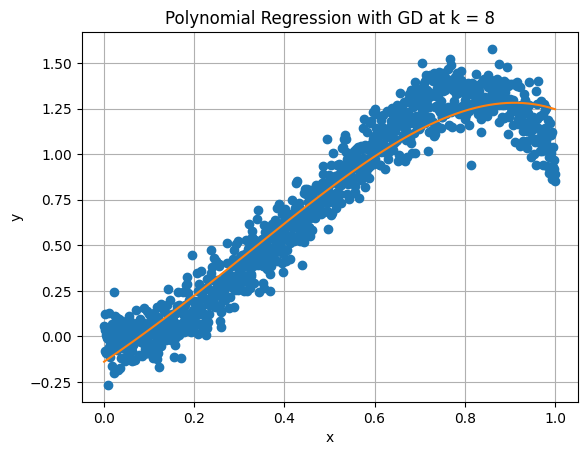

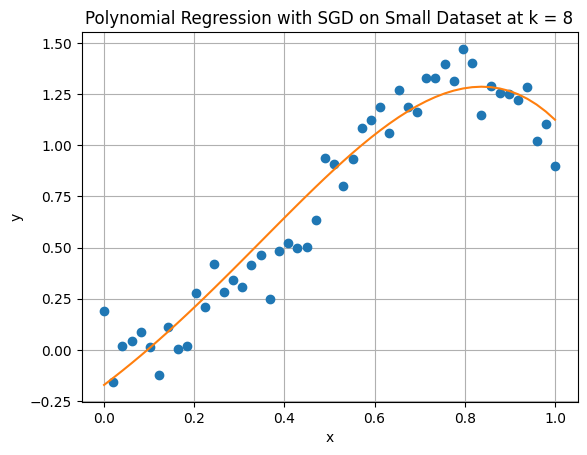

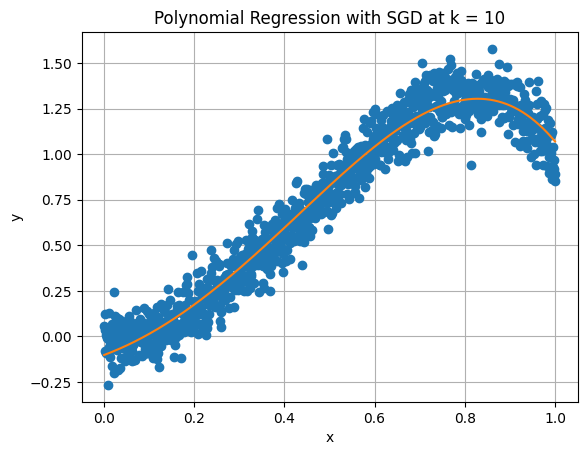

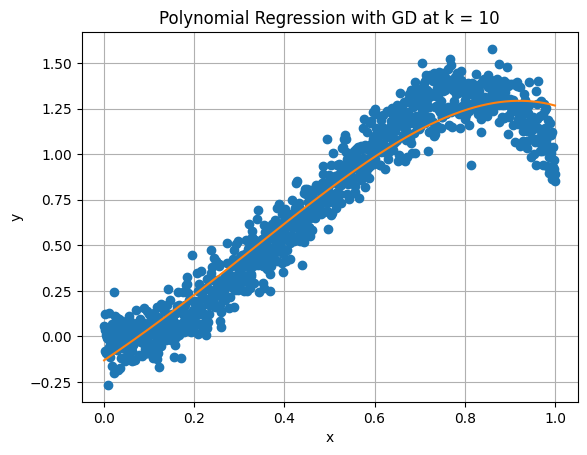

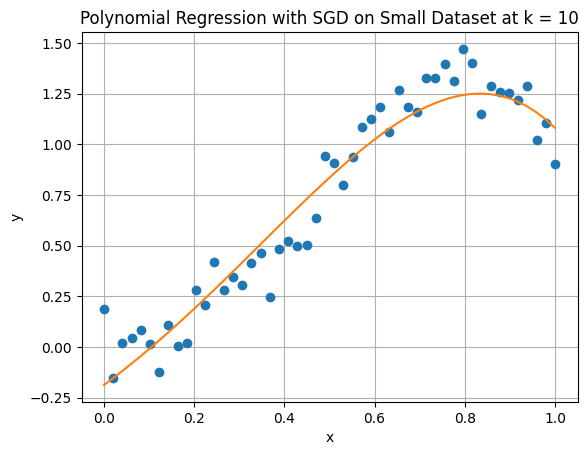

In [33]:
# Repeat the experiment by varying the degree K of the polynomial

K_vals = [3, 5, 8, 10]
theta_true_k5 = np.array([0, 0, 4, 0, -3]) 

sgd_losses = []
gd_losses = []
sgd_small_losses = []

for k in K_vals:
    # SGD
        # Train the polynomial regression model on the training set via the Stochastic Gradient Descent algorithm
    phiX = vandermonde(x, K)

    # Split the data
    (train_X, train_y), (test_X, test_y) = split_data(phiX, y)

    # initialize infos
    theta0 = np.zeros(K)
    alpha = 0.1
    batch_size = 25
    n_epochs = 500

    # Train SGD model
    theta_history_sgd, loss_history_sgd, grad_norm_history_sgd = SGD(loss, grad_loss, (train_X, train_y), theta0, alpha, batch_size, n_epochs)

    # Test the model
    test_loss_sgd = loss(theta_history_sgd[-1], test_X, test_y)
    sgd_losses.append(test_loss_sgd)

    plt.plot(x, y, 'o')
    plt.plot(x, f(phiX, theta_history_sgd[-1]))
    plt.title(f"Polynomial Regression with SGD at k = {k}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()

    # Loss and gradient function for GD
    def f_loss(theta):
        return loss(theta, train_X, train_y)

    def f_grad_loss(theta):
        return grad_loss(theta, train_X, train_y)

    # Train GD model
    x_sol, b, f_val, grad_norm = GD(f_loss, f_grad_loss, theta0, alpha=0.08)

    # Test the model
    test_loss_gd = loss(x_sol, test_X, test_y)
    gd_losses.append(test_loss_gd)

    # Plot the result
    plt.plot(x, y, 'o')
    plt.plot(x, f(phiX, x_sol), '-')
    plt.title(f"Polynomial Regression with GD at k = {k}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()

    # Train the polynomial regression model on the training set via the Stochastic Gradient Descent algorithm
    phiX_small = vandermonde(x_small, K)

    # initialize infos
    theta0 = np.zeros(K)
    alpha = 0.25
    batch_size = 30
    n_epochs = 500

    # Train SGD model
    theta_history_sgd_small, loss_history_sgd_small, grad_norm_history_sgd_small = SGD(loss, grad_loss, (phiX_small, y_small), theta0, alpha, batch_size, n_epochs)

    # Test the model
    test_loss_sgd_small = loss(theta_history_sgd_small[-1], phiX_small, y_small)
    sgd_small_losses.append(test_loss_sgd_small)

    plt.plot(x_small, y_small, 'o')
    plt.plot(x_small, f(phiX_small, theta_history_sgd_small[-1]))
    plt.title(f"Polynomial Regression with SGD on Small Dataset at k = {k}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()

    if (k == 5):
        print(f'The true paramters are {theta_true_k5}')
        print(f'The SGD paramters are {theta_history_sgd[-1]}')
        print(f'The GD paramters are {x_sol}')
        print(f'The SGD paramters are {theta_history_sgd_small[-1]}')

### Compare the parameters learned by the three models with the true parameter

The true paramters are [ 0  0  4  0 -3]<br>
The SGD paramters are [-0.10450227  0.95982187  2.30392994  0.23601489 -2.31439336]<br>
The GD paramters are [-0.13798544  1.67521285  0.74542155 -0.18102428 -0.84825075]<br>
The SGD paramters are [-0.18058642  1.65763373  1.23552494 -0.15256621 -1.45726854]<br>